In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore

from collections import defaultdict, Counter

# Load annotations

In [7]:
cell_line_info = pd.read_csv("../data/sample_info.csv")
cell_line_annotations = pd.read_excel("../data/41586_2019_1186_MOESM4_ESM.xlsx",
                                      sheet_name="Cell Line Annotations")

hs_muts = pd.read_hdf("../data/hs_muts.h5",key="hs_muts")
damaging_muts = pd.read_hdf("../data/damaging_muts.h5",key="damaging_muts")
tertp = pd.read_excel("../data/41586_2019_1186_MOESM8_ESM.xlsx",skiprows=4)

fusions = pd.read_csv("../data/CCLE_Fusions_20181130.txt",sep="\t")
copynumber = pd.read_hdf("../data/CCLE_gene_cn.hdf",key="copynumber")
copynumber = copynumber.dropna(how="any",thresh=1000,axis=1)

tss1kb_meth = pd.read_hdf("../data/CCLE_RRBS_TSS1kb_20181022.hdf",key="tss1kb_meth")

ccle_genex = pd.read_hdf("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",key="ccle_genex")
exonusage = pd.read_hdf("../data/CCLE_RNAseq_ExonUsageRatio_20180929.hdf",key="exonusage")

mirna = pd.read_hdf("../data/CCLE_miRNA_20181103.hdf",key="mirna")
chromatin_profiling = pd.read_hdf("../data/CCLE_GlobalChromatinProfiling_20181130.hdf",key="chromatin_profiling")
rppa = pd.read_hdf("../data/CCLE_RPPA_20181003.hdf",key="rppa")

msi = pd.read_excel("../data/41586_2019_1186_MOESM10_ESM.xlsx",sheet_name="MSI calls")
absolute = pd.read_excel("../data/CCLE_ABSOLUTE_combined_20181227.xlsx",
                         sheet_name = "ABSOLUTE_combined.table")

# Cell line primary sites

In [59]:
subtypes = cell_line_annotations[["depMapID","type_refined"]].set_index("depMapID")
subtypes = subtypes["type_refined"]
subtypes = subtypes.dropna()
subtypes = subtypes.apply(lambda x: x.capitalize().replace("_"," "))

rename_map = {"T-cell lymphoma other":"Other T-cell lymphoma",
              "Aml":"AML",
              "Ewings sarcoma": "Ewing's sarcoma",
              "Fibroblast like":"Fibroblast-like",
              "Lung nsc":"Lunc, NSC",
              "Lymphoma hodgkin":"Hodgkin's lymphoma",
              "Lymphoma dlbcl":"DLBCL",
              "T-cell all":"T-cell ALL",
              "B-cell all":"B-cell ALL",
              "Cml":"CML",
              "B-cell lymphoma other":"Other B-cell lymphoma",
              "Leukemia other":"Other leukemia"
             }

subtypes = subtypes.apply(lambda x:rename_map.get(x,x))

# Top recurrent mutations

In [16]:
def get_top_muts():
    
    align_hs_muts, align_damaging_muts = hs_muts.align(damaging_muts,join="outer",axis=1)
    align_hs_muts = align_hs_muts.fillna(0)
    align_damaging_muts = align_damaging_muts.fillna(0)
    
    hs_damaging_muts = (align_hs_muts+align_damaging_muts).clip(0,1)
        
    mut_totals = hs_damaging_muts.sum()
    mut_totals = mut_totals.sort_values()
    
    return hs_damaging_muts[mut_totals.index[-8:]]
    
muts = get_top_muts()

# Fusions

In [17]:
def get_fusions():

    fusions["value"] = 1

    fusions_mat = pd.pivot_table(fusions, values="value",
                                index=["BroadID"], columns="X.FusionName", fill_value=0)
    
    fusions_mat.columns = fusions_mat.columns.map(lambda x: x.replace("--","-"))

    return fusions_mat[["BCR-ABL1","EWSR1-FLI1","KMT2A-MLLT3"]]

select_fusions = get_fusions()

# Top continuous annotations

In [18]:
def top_variable(annotations, top_n,clip_left=-3,clip_right=3):
    
    stdevs = annotations.std()
    stdevs = stdevs.sort_values()
    
    top_names = stdevs.index[-top_n:]
    
    top_annotations = annotations[top_names]
    top_annotations = (top_annotations - top_annotations.mean())/top_annotations.std()
    
    top_annotations = top_annotations.clip(clip_left,clip_right)
    
    return top_annotations

In [19]:
select_copynumber = top_variable(copynumber, 1000)
select_meth = top_variable(tss1kb_meth, 1000)
select_genex = top_variable(ccle_genex, 1000)
select_exonusage = top_variable(exonusage, 1000)
select_mirna = top_variable(mirna, 1000)
select_chromatin = top_variable(chromatin_profiling, 1000)
select_rppa = top_variable(rppa, 1000)

# MSI, ploidy, and ancestry

In [20]:
is_msi = msi[msi["CCLE.MSI.call"].isin(['inferred-MSI','inferred-MSS'])]
is_msi = is_msi[["depMapID","CCLE.MSI.call"]].set_index("depMapID")
is_msi = is_msi == "inferred-MSI"

ploidy = absolute[["depMapID","ploidy"]].set_index("depMapID")
ancestry = cell_line_annotations[["inferred_ancestry","depMapID"]].set_index("depMapID").dropna()

# Cluster subtypes

In [60]:
cluster_df = pd.concat([select_copynumber,
                        select_meth,
                        select_genex,
                        select_exonusage,
                        select_mirna,
                        select_chromatin,
                        select_rppa
                       ],join="outer",axis=1,sort=True)

cluster_df, align_subtypes = cluster_df.align(subtypes,axis=0,join="inner")

In [49]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

subtype_means = cluster_df.groupby(align_subtypes).mean()

cpg_linkage = hc.linkage(subtype_means.fillna(subtype_means.mean()), method='ward')

In [58]:
subtype_means.index[leaf_order]

Index(['Lymphoma burkitt', 'Lymphoma dlbcl', 'Other B-cell lymphoma',
       'Multiple myeloma', 'Hodgkin's lymphoma', 'Other T-cell lymphoma',
       'AML', 'CML', 'T-cell ALL', 'B-cell ALL', 'Other leukemia', 'Other',
       'Bile duct', 'Pancreas', 'Colorectal', 'Stomach', 'Cervix', 'Esophagus',
       'Upper aerodigestive', 'Urinary tract', 'Breast', 'Lunc, NSC',
       'Lung small cell', 'Prostate', 'Medulloblastoma', 'Ewing's sarcoma',
       'Neuroblastoma', 'Fibroblast-like', 'Giant cell tumour', 'Liver',
       'Endometrium', 'Ovary', 'Kidney', 'Mesothelioma', 'Chondrosarcoma',
       'Meningioma', 'Osteosarcoma', 'Melanoma', 'Soft tissue', 'Glioma',
       'Thyroid'],
      dtype='object', name='type_refined')

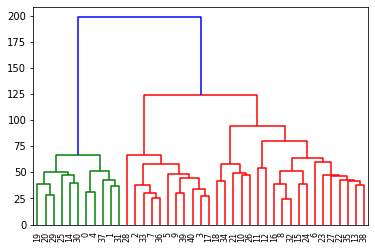

In [55]:
leaf_order = hc.dendrogram(cpg_linkage)["leaves"]